In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DataExploration import DataExploration
from DataPreprocessing import DataPreprocessing
from ModelOptimization import ModelOptimization
from sklearn.model_selection import train_test_split
import random

In [2]:
seed = 100

In [3]:
# Load image data
X = np.load("emnist_hex_images.npy")
y = np.load("emnist_hex_labels.npy")

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, train_size=0.8, random_state=seed
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(86241, 400) (86241,)
(21561, 400) (21561,)


In [5]:
dpp = DataPreprocessing()
# color filter for exploration
filtered_training = dpp.filter_color_values(X_train)

## Data exploration

### Pixel Distribution

The majority of pixels in the dataset have the value 0, e.g completely black.
Most of the pixels in the lower end can be attributed to noise in the dataset.
Pixels in the upper end makes up the digits in the dataset.
Values in between are either noise or details. I decided to keep most of the 
values in between to preserve details, but reduce some noise as you will see 
in the image comparison later in this report.

Pixels with values less than 35 are set to 0, and pixels over 250 are set to 255.


In [6]:
de_raw = DataExploration(X_train, y_train)
de_filtered = DataExploration(filtered_training, y_train)

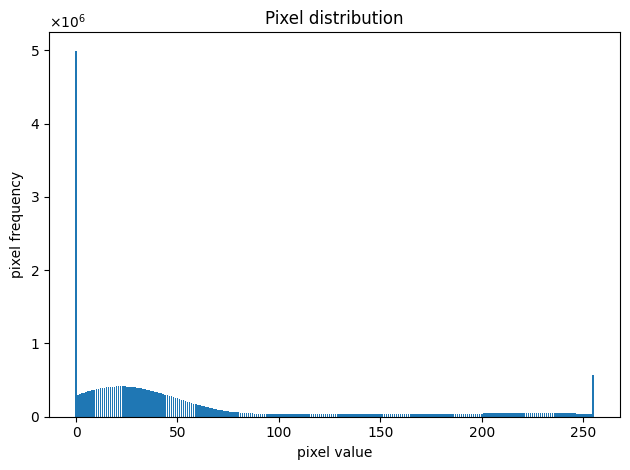

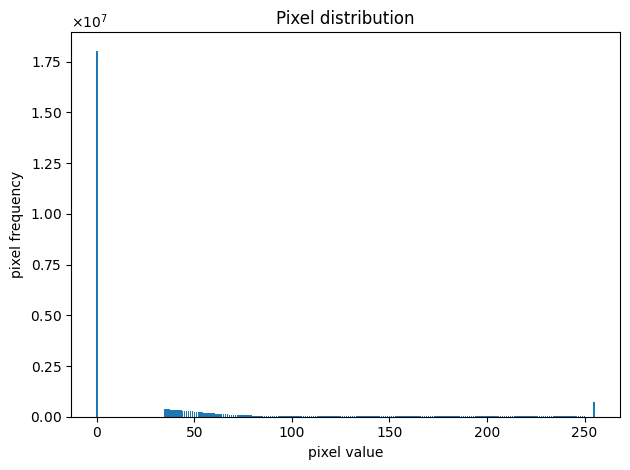

In [7]:
de_raw.display_pixel_distribution()
de_filtered.display_pixel_distribution()

As you can see below, the image after processing still contains noise.
However, it separates the digit from the noise, making it easier to distinguish 
features, while still preserving details.

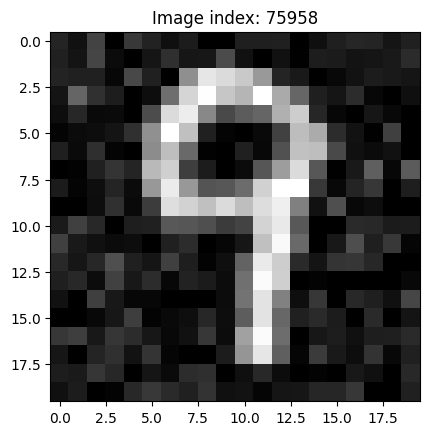

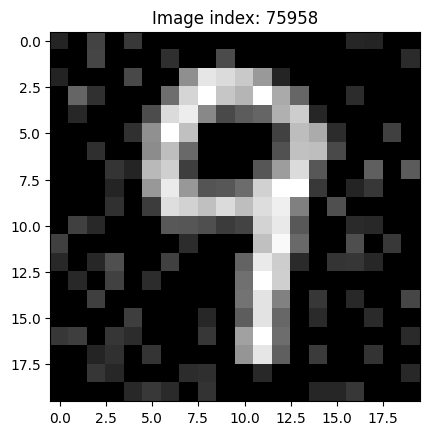

In [8]:
# Image before and after color filtering
index = random.randint(0,len(y_train))
de_raw.display_image(index=index)
de_filtered.display_image(index=index)

### Class distribution

There is more data on digits than letters. With the letters B(11), D(13), and E(14)
occupying a smaller portion than the rest of the letters.
The dataset is unbalanced and could therfore lead to better predictions on
digits than letters.

I am using StratifiedKfold cross validation to mitigate the uneven class distribution.
This preserves the distribution when running cross validation. The models will not 
be skewed as much towards the majority classes. I could also have used over/undersampling, but
decided not to.

My prediction on model performance:

- The model could struggle to differantiate between B and 8, 0 and D, as these digits are similar w
- The model could have a lower accuracy on E, since there is less available data on it.
- Empty labels could be easy to predict, since there is almost no white pixel values in those images


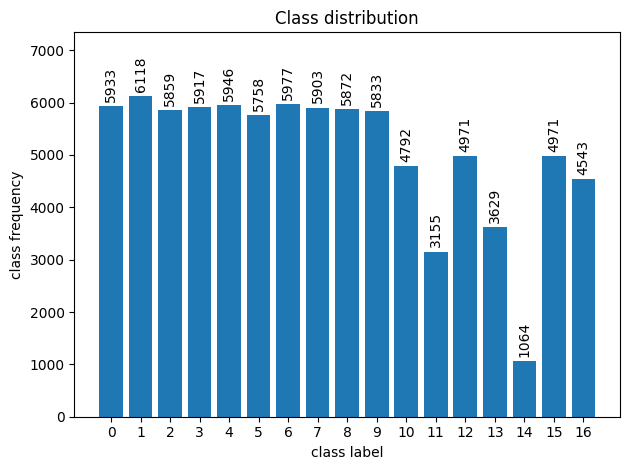

In [9]:
de_raw.display_class_distribution()


# Results

In [10]:
from ModelOptimization import ModelOptimization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from time import time

### Training of models

Models are pretrained from the train_and_save.py script which uses the ModelOptimization class.
In ModelOptimization.py you will find all the code used for training and cross validation.

Training has been done using the same seed as in this notebook.

#### Preprocessing

Color filtering and linear scaling has been applied to the feature columns. (Explanation of color filtering earlier in the notebook).
Applying linear scaling to the data had no effect on model performance, but decreased training time.


In [11]:
X_train = dpp.process_data(X_train)
X_filtered = dpp.filter_color_values(X_test)
X_test = dpp.process_data(X_test)
label_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "EMPTY"])

In [12]:
mo = ModelOptimization(random_state=seed)
models = mo.load_trained_models()

### Chosen models and hyperparameters

For this assignment I have chosen 4 classification models:

- Support Vector Classifier
- KNeareshNeighbor Classifier
- Random Forest Classifier
- MultiLayer Perceptron Classifier

Due to the amount of time needed for training, some hyperparameters are left out. 
To determine which hyperparameters to use for each model, I trained each model
on a smaller amount of the training data and compared validation accuracy for the different 
parameter combinations. The best combinations were kept, while others discarded. Here is 
the parameters for each model that are used.

#### Support Vector Classifier

- kernel: rbf
- gamma: 0.1, 0.01, 0.001, 0.0001
- C: 1, 10, 100, 1000

#### Random Forest Classifier

- criterion: gini, entropy
- max_features: sqrt, log2
- min_samples_split: 2, 6, 10

#### KNearest Neighbors Classifier

- n_neighbors: range from 1 to 21 included
- weights: uniform, distance
- metric: manhattan, minkowski, euclidean

#### Multi Layer Perceptron Classifier

- hidden_layer_sizes: (50,), (100,), (200,), (300,), (50, 10), (100, 20), (200, 40), (300, 80)
- activation: tanh, relu
- alpha: 0.0001, 0.001, 0.01

### Validation Results

In [13]:
# Create a dictionary with validation results for easier access
model_results = dict()
for name, values in models.items():
    model = values[0]
    val_score = values[1]
    fit_time = values[2]
    pred_time = values[3]
    total_time = values[4]

    model_results.update({
        name: {
            "val_score": val_score,
            "val_fit_time": fit_time,
            "val_pred_time": pred_time,
            "cv_total_time": total_time,
        }
    })

In [14]:
def validation_accuracy_pred_time():
    """
    Plots validation accuracy compared with validation prediction time
    """
    for model, results in model_results.items():
        print(model)
        print(f"Validation score:\t{round(results['val_score'],5)}")
        print(f"Fit time:\t\t{round(results['val_fit_time'],2)}s")
        print(f"Prediction time:\t{round(results['val_pred_time'],2)}s")
        print(f"Total validation time:\t{round(results['cv_total_time']/60,2)}min")
        print()
        
    names = [x for x in model_results.keys()]#[:-1]
    val_scores = [x["val_score"] for x in model_results.values()]#[:-1]
    pred_times = [x["val_pred_time"] for x in model_results.values()]#[:-1]
    min_x = np.argmin(pred_times)
    min_y = np.min(pred_times)

    fig, ax1 = plt.subplots()
    ax1.set_ylim(0.9, 1)
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Validation accuracy", color="blue")
    ax1.bar(names,val_scores, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Prediction time in seconds", color="red")
    ax2.plot(names, pred_times, color="red")
    ax2.scatter(min_x, min_y, c="green", label="lowest prediction time")
    ax2.tick_params(axis='y', labelcolor="red")

    plt.title("Validation Results")
    plt.legend(fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.show()

#### Model selection
I am choosing the model with the highest validation accuracy.
However, as prediction time could be considered important for the given task,
I have included it in visual comparison.

The given task is to predict lables on a conveyor belt, and therefore
prediction time could also be important.


SVC
Validation score:	0.96687
Fit time:		1146.48s
Prediction time:	322.52s
Total validation time:	187.5min

KNN
Validation score:	0.94622
Fit time:		0.09s
Prediction time:	20.53s
Total validation time:	60.86min

RandomForest
Validation score:	0.93446
Fit time:		67.35s
Prediction time:	0.46s
Total validation time:	7.78min

MLPC
Validation score:	0.96518
Fit time:		253.71s
Prediction time:	0.21s
Total validation time:	102.68min



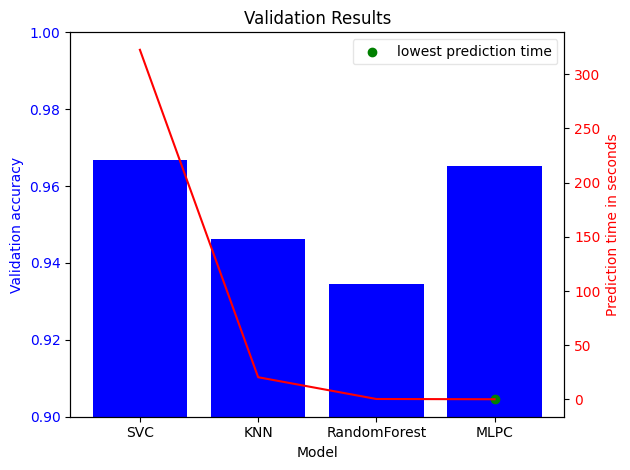

In [15]:
validation_accuracy_pred_time()

In [16]:
# Sort models by prediction time and accuracy
#models_score_time = [(name,vals["val_score"],vals["val_pred_time"]) for name, vals in model_results.items()]
#order = sorted(models_score_time, key=lambda x: (x[2], -x[1]))
#best_key = order[0][0]

best_key = max(model_results, key=lambda x: model_results[x].get("val_score", 0))

print(f"Best model name: {best_key}")
best_model = models[best_key][0]
print(f"Best model with parameters:\n{best_model}")

Best model name: SVC
Best model with parameters:
SVC(C=10, gamma=0.1, random_state=100)


In [17]:
# Note: times will vary each run and depending on hardware
pred_start = time()
prediction = best_model.predict(X_test)
pred_end = time()

total_prediction_time = (pred_end-pred_start) #/averaging_factor
single_prediction_time = total_prediction_time / y_test.shape[0]
print(f"Total prediction time: {round(total_prediction_time, 5)}s")
print(f"Single average prediction time: {round(single_prediction_time, 8):f}s")

Total prediction time: 245.93733s
Single average prediction time: 0.011407s


In [18]:
# Validation vs Test accuracy
validation_score = model_results[best_key]["val_score"]
print(f"Validation accuracy: {round(validation_score, 5)}")
test_score = accuracy_score(y_test, prediction)
print(f"Test accuracy: {round(test_score, 5)}")
difference = test_score - validation_score
print(f"Improvement from validation: {difference:f}")

Validation accuracy: 0.96687
Test accuracy: 0.96874
Improvement from validation: 0.001868


#### Chosen model results

Test accuracy is slightly higher than validation accuracy, which means the model is probably underfitting and 
further improvements could be made.

If I had more time, I could have used more parameters when running cross validation.


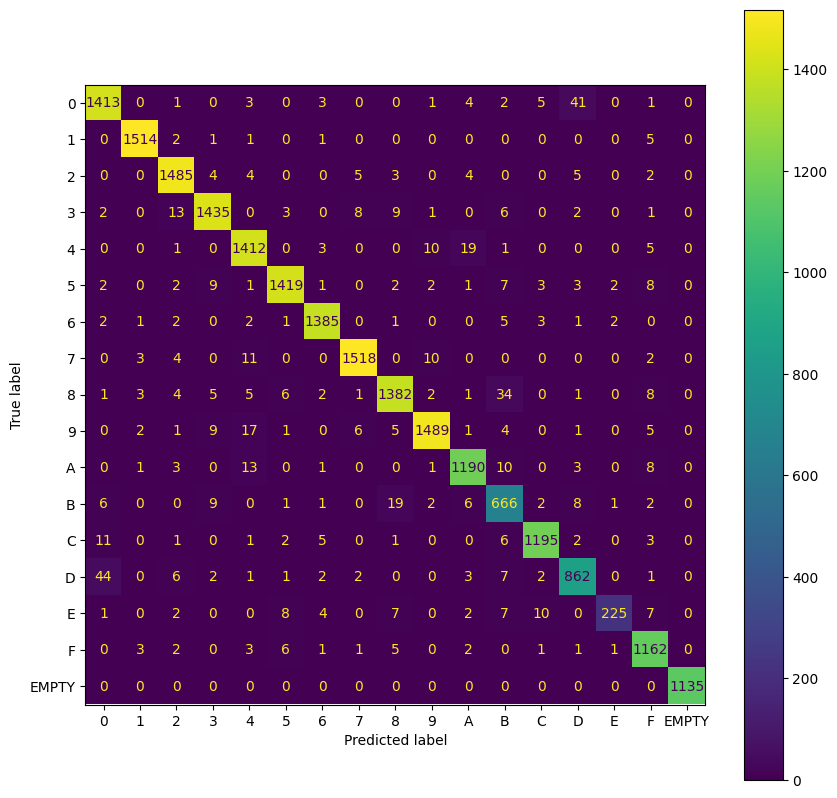

In [19]:
# Confusion matrix to observe prediction of differente labels
conf_matrix = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

Looking at the confusion matrix, the model predicts the correct label most of the time.
The model seems to struggle somewhat between D and 0. More cases of wrong predictions of 0 than D.

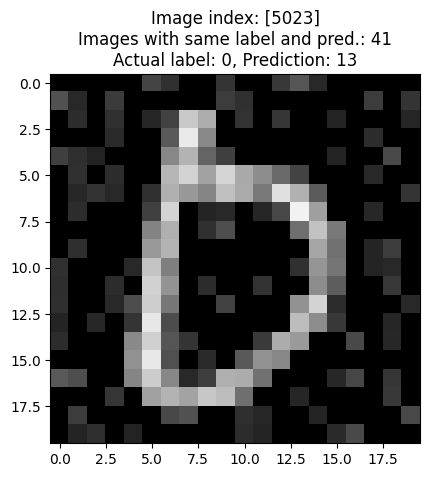

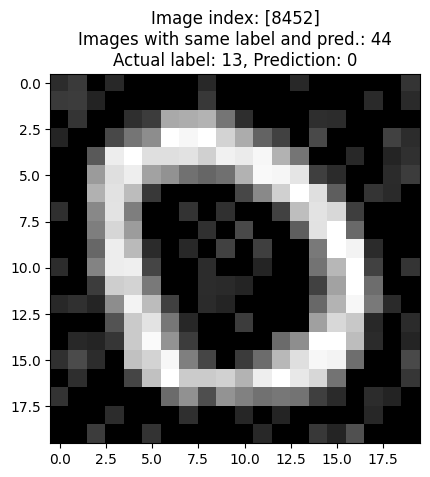

In [20]:
de = DataExploration(X_filtered, y_test)
de.display_label_prediction(0, 13, prediction)
de.display_label_prediction(13, 0, prediction)

Predicted 8 when it actually was B confused the model more than the opposite.

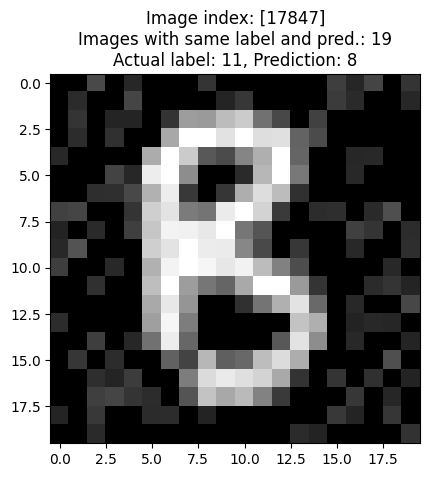

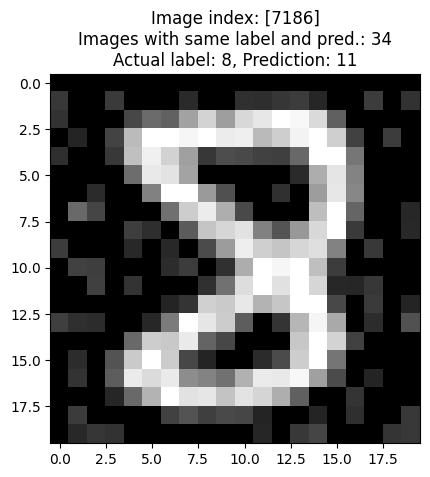

In [21]:
de.display_label_prediction(11,8,prediction)
de.display_label_prediction(8,11,prediction)

The model did not struggle with predicting emtpy labels.
The model did not struggle to predict E. The most likely reason for this, is the use of stratifeid kfold when cross validating.

In [22]:
# Classification report for different performance metrics
clf_report = classification_report(y_test, prediction, target_names=label_names)
print(clf_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1474
           1       0.99      0.99      0.99      1524
           2       0.97      0.98      0.98      1512
           3       0.97      0.97      0.97      1480
           4       0.96      0.97      0.97      1451
           5       0.98      0.97      0.98      1462
           6       0.98      0.99      0.98      1405
           7       0.99      0.98      0.98      1548
           8       0.96      0.95      0.96      1455
           9       0.98      0.97      0.97      1541
           A       0.97      0.97      0.97      1230
           B       0.88      0.92      0.90       723
           C       0.98      0.97      0.98      1227
           D       0.93      0.92      0.93       933
           E       0.97      0.82      0.89       273
           F       0.95      0.98      0.97      1188
       EMPTY       1.00      1.00      1.00      1135

    accuracy              